# Data Analysis

This notebooks contains the exploratory data analysis of the data used to predict the severity of the collisions in the city of Seattle in Canada. The main objective is to build a highly accurated machine learning model using the available data.The database used was provided by the city if seattle and can be found at: http://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0 
The first setep it's to install and import the necessary libraries to make the analysis and ploting of the data:

In [1]:
%%capture
! pip install seaborn
! pip install dexplot

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io
import requests
from scipy import stats
import datetime
import dexplot as dxp

Then i loaded the data a decoded it:

In [4]:
url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [5]:
c.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757,47.609408,1,328476,329976,EA08706,Matched,Block,NaN,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
1,-122.319561,47.662221,2,328142,329642,EA06882,Matched,Block,NaN,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,...,Dry,Daylight,NaN,NaN,NaN,32,One parked--one moving,0,0,Y
2,-122.327525,47.604393,3,20700,20700,1181833,Unmatched,Block,NaN,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,...,NaN,NaN,NaN,4030032.0,NaN,NaN,NaN,0,0,N
3,-122.327525,47.708622,4,332126,333626,M16001640,Unmatched,Block,NaN,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NOR...,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
4,-122.292120,47.559009,5,328238,329738,3857118,Unmatched,Block,NaN,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND...,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


## Data exploration

In this section i chose the variables that i'm going to use to make the prediction, i took the variables that showed a relation with the target, and didn't have a lot of null values.

In [6]:
c.drop(c.columns.difference(['SEVERITYCODE','ADDRTYPE','WEATHER','ROADCOND','LIGHTCOND','VEHCOUNT','COLLISIONTYPE','INCDATE','PEDCOUNT']), 1, inplace=True)
c.head()

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,VEHCOUNT,INCDATE,WEATHER,ROADCOND,LIGHTCOND
0,Block,1,Sideswipe,0,2,2020/01/22 00:00:00+00,Raining,Wet,Dark - Street Lights On
1,Block,1,Parked Car,0,2,2020/01/07 00:00:00+00,Clear,Dry,Daylight
2,Block,0,NaN,0,0,2004/01/30 00:00:00+00,NaN,NaN,NaN
3,Block,0,NaN,0,0,2016/01/23 00:00:00+00,NaN,NaN,NaN
4,Block,0,NaN,0,0,2020/01/26 00:00:00+00,NaN,NaN,NaN


Here i droped the null values in the dataframe and reseted the index

In [7]:
c.isnull().sum()
c.dropna(inplace=True)
c= c.reset_index(drop=True)
c.isnull().sum()

ADDRTYPE         0
SEVERITYCODE     0
COLLISIONTYPE    0
PEDCOUNT         0
VEHCOUNT         0
INCDATE          0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
dtype: int64

I droped the rows with severity unknown, i can't get information from that, also i checked for the quantity of each severity registered

In [8]:
c = c[c.SEVERITYCODE != '0']
c['SEVERITYCODE'].value_counts()

1     131922
2      57553
2b      3045
3        339
Name: SEVERITYCODE, dtype: int64

I took the date data and convert it to a number that indicates the day of the week

In [9]:
c['INCDATE'], c['B'] = c['INCDATE'].str.split(' ', 1).str
c['INCDATE'] =  pd.to_datetime(c['INCDATE']).dt.dayofweek
c.head()

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,VEHCOUNT,INCDATE,WEATHER,ROADCOND,LIGHTCOND,B
0,Block,1,Sideswipe,0,2,2,Raining,Wet,Dark - Street Lights On,00:00:00+00
1,Block,1,Parked Car,0,2,1,Clear,Dry,Daylight,00:00:00+00
2,Block,1,Rear Ended,0,2,3,Clear,Dry,Daylight,00:00:00+00
3,Block,1,Other,0,1,0,Clear,Wet,Daylight,00:00:00+00
4,Intersection,1,Sideswipe,0,2,3,Overcast,Dry,Daylight,00:00:00+00


Then i just counted the number of variables of each row to drop the values of which don't provide clear informartion

In [10]:
print(c['ADDRTYPE'].value_counts())
print(c['WEATHER'].value_counts())
print(c['ROADCOND'].value_counts())
print(c['LIGHTCOND'].value_counts())
print(c['COLLISIONTYPE'].value_counts())
print(c['INCDATE'].value_counts())
c.drop(columns=['B'])
c = c[c.WEATHER != 'Unknown'] 
c = c[c.WEATHER != 'Other'] 
c = c[c.ROADCOND != 'Unknown'] 
c = c[c.ROADCOND != 'Other'] 
c = c[c.LIGHTCOND != 'Unknown'] 
c = c[c.LIGHTCOND != 'Other'] 
c = c[c.LIGHTCOND != 'Dark - Unknown Lighting'] 
c = c[c.LIGHTCOND != 'COLLISIONTYPE']

Block           126239
Intersection     65865
Alley              755
Name: ADDRTYPE, dtype: int64
Clear                       114037
Raining                      33857
Overcast                     28371
Unknown                      14097
Snowing                        908
Other                          818
Fog/Smog/Smoke                 571
Sleet/Hail/Freezing Rain       115
Blowing Sand/Dirt               49
Severe Crosswind                26
Partly Cloudy                   10
Name: WEATHER, dtype: int64
Dry               127731
Wet                48464
Unknown            14065
Ice                 1215
Snow/Slush          1002
Other                128
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64
Daylight                    118697
Dark - Street Lights On      49840
Unknown                      12656
Dusk                          6022
Dawn                          2595
Dark - No Street Lights       1567
Dark - Street Lights Off 

Here i printed each value of the variables grouped with the normalized severity code to visualize the distribution of the data


In [11]:
print(c.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['VEHCOUNT'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['INCDATE'])['SEVERITYCODE'].value_counts(normalize=True))

ADDRTYPE      SEVERITYCODE
Alley         1               0.861386
              2               0.130363
              2b              0.008251
Block         1               0.721975
              2               0.263080
              2b              0.013284
              3               0.001661
Intersection  1               0.547603
              2               0.426293
              2b              0.023747
              3               0.002357
Name: SEVERITYCODE, dtype: float64
WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.714286
                          2               0.285714
Clear                     1               0.658696
                          2               0.321397
                          2b              0.017896
                          3               0.002011
Fog/Smog/Smoke            1               0.659459
                          2               0.329730
                          2b              0.005405
           

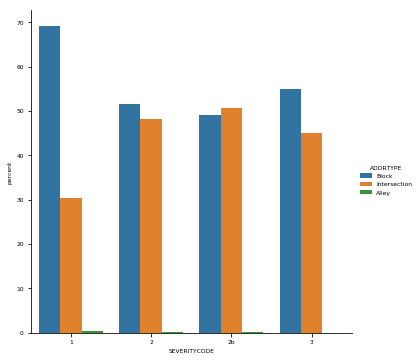

In [17]:
x,y = 'SEVERITYCODE', 'ADDRTYPE'

(c
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
